# Stochastic Variance Reduction Methods for Policy Evaluation

## Convex Optimization: Project

### Team Members:

- Gautham Bellamkonda
- Pranav Kalsanka Nayak


# Problem Statement

Consider the minimization of objective in equation (7) in https://proceedings.mlr.press/v70/du17a/du17a.pdf. Find a dual of min (7) by eliminating $\theta$ from equation (10). Highlight the formula for computing the primal solution using the dual solution. Since the primal and dual are unconstrained quadratics, one can solve them using accelerated gradient descent. Note that the per iteration cost is $O(nd^2)$ (assume $n\ge d$) for both primal and dual algos. We already know for reaching $\epsilon$ optimal solution we need $\log(\frac{1}{\epsilon})$ iterations. The paper proposes to solve something "in-between" the primal and dual (saddle-point form), which is equation (10). This problem has both primal and dual variables. The idea is to perform block coordinate (gradient based) descent\&ascent  on primal\&dual variables. The algorithm is in equation (12). The advantage is computing (12) requires only $O(nd)$. Interestingly, in theorem~1, they show this algorithm  also has linear convergence i.e., for reaching $\epsilon$ optimal solution we need $\log(\frac{1}{\epsilon})$ iterations. Thus primal and dual algorithms shall be worse than the proposed primal-dual algorithm.


### a

Derive a dual of min (7) by eliminating $\theta$ from equation (10). Highlight the formula for computing the primal solution using the dual solution.

Equation (7) describes the minimization objective:

$$
\text{MSPBE}(\theta) = \frac{1}{2} \| \hat A \theta - \hat b \|^2_{\hat C^{-1}} + \frac{\rho}{2} \| \theta \|^2
$$

To minimize this objective with respect to $\theta$, we introduce the dual variable $w$ and write the Lagrangian as:

$$
\mathcal{L}(\theta, w) = \frac{\rho}{2} \| \theta \|^2 - w^T \hat A \theta - (\frac{1}{2} w^T \hat C w - w^T \hat b)
$$

<!-- Minimizing MSPBE with respect to $\theta$ is equivalent to solving  -->

<!-- $$ -->
<!-- % \min_{\theta} \max_{w} \mathcal{L}(\theta, w) -->
<!-- % $$ -->

Taking the gradient of $\mathcal{L}(\theta, w)$ with respect to $\theta$ and setting it to zero, we get:

\begin{align*}
\rho \theta - \hat A^T w &= 0\\
\theta &= \frac{\hat A^T w}{\rho}
\end{align*}

Substituting this back into the Lagrangian, we get the dual objective:

\begin{align*}
\max_{w} g(w) &= \max_{w} -\frac{1}{2 \rho} w^T \hat A \hat A^T w - (\frac{1}{2} w^T \hat C w - w^T \hat b)\\
&= \max_{w} -\frac{1}{2 \rho} w^T \hat A \hat A^T w - \frac{1}{2} w^T \hat C w + w^T \hat b\\
&= \max_{w} -\frac{1}{2 \rho} w^T (\hat A \hat A^T + \rho \hat C) w + w^T \hat b\\
&= \min_{w} \frac{1}{2 \rho} w^T (\hat A \hat A^T + \rho \hat C) w - w^T \hat b
\end{align*}

The primal solution can be computed using the dual solution as:

$$
\theta^* = \frac{\hat A^T w^*}{\rho}
$$


In [42]:
# code accelerated gradient descent for the primal problem

import numpy as np
import matplotlib.pyplot as plt
import time

In [43]:
# MDP with 400 states and 10 actions. 

NUM_STATES = 400
NUM_ACTIONS = 10
GAMMA = 0.95

# states are represented by 201 dimensional vectors, where the first 200 dimensions are sampled from U[0, 1]
# the last dimension is 1
states = np.random.rand(NUM_STATES, 200)
states = np.concatenate((states, np.ones((NUM_STATES, 1))), axis=1)

# transition probabilities are sampled from U[0, 1]

transition_prob = np.random.rand(NUM_STATES, NUM_ACTIONS, NUM_STATES) + 1e-5
transition_prob = transition_prob / np.sum(transition_prob, axis=2, keepdims=True)

# policy is sampled from U[0, 1]
policy = np.random.rand(NUM_STATES, NUM_ACTIONS) + 1e-5
policy = policy / np.sum(policy, axis=1, keepdims=True)

# start distribution is sampled from U[0, 1]
start_distribution = np.random.rand(NUM_STATES) + 1e-5
start_distribution = start_distribution / np.sum(start_distribution)

# reward function is sampled from U[0, 1]
reward = np.random.rand(NUM_STATES, NUM_ACTIONS) + 1e-5

# sample transitions for T = 20_000
T = 20_000
A = np.zeros((201, 201))
b = np.zeros(201)
C = np.zeros((201, 201))

state = np.random.choice(NUM_STATES, p=start_distribution)
for t in range(T):
    action = np.random.choice(NUM_ACTIONS, p=policy[state])
    next_state = np.random.choice(NUM_STATES, p=transition_prob[state, action])
    r = reward[state, action]
    A += np.outer(states[state], states[state] - GAMMA * states[next_state])
    b += r * states[state]
    C += np.outer(states[state], states[state])
    state = next_state

A /= T
b /= T
C /= T

In [44]:
n = 201

rho = 0.1

hessian = A.T @ np.linalg.pinv(C) @ A + rho * np.eye(n)
eigvals = np.linalg.eigvals(hessian)
L = L_rho = np.max(eigvals)
mu_rho = np.min(eigvals)

dual_hessian = (A @ A.T)/rho + C
dual_eigvals = np.linalg.eigvals(dual_hessian)
L_dual = np.max(dual_eigvals)

mu = 1/L_dual
mu_dual = 1/L

eigenC = np.linalg.eigvals(C)
lambda_min = np.min(eigenC)
lambda_max = np.max(eigenC)

def primal_objective(theta):    # O(d^3)
    return 0.5*((A @ theta - b).T @ np.linalg.pinv(C) @ (A @ theta - b) + rho*np.linalg.norm(theta)**2)
    # return  rho*np.linalg.norm(theta)**2

def primal_gradient(theta):    # O(d^3)
    return A.T @ np.linalg.pinv(C) @ (A @ theta - b) + rho * theta
    # return rho * theta

def dual_objective(w):       # O(d^2.3)
    return -1/(2*rho) *  w.T @ (A@A.T + rho*C) @ w + w.T @ b

def dual_gradient(w):           # O(d^2.3)
    return -1/rho * (A@A.T + rho*C) @ w + b

def lagrangian(theta, w):       # O(d^2)
    return ((rho/2) * theta.T@theta) - w.T @ A @ theta - 0.5 * w.T @ C @ w + w.T @ b

def lagrangian_gradient_primal(theta, w):       # O(d^2)
    return rho * theta - A.T @ w

def lagrangian_gradient_dual(theta, w):     # O(d^2)
    return b - (A @ theta) - (C @ w) 

def optimal_primal():
    return np.linalg.pinv(hessian) @ A.T @ np.linalg.pinv(C) @ b

def optimal_dual():
    return np.linalg.pinv(C) @ (b - A.T @ optimal_primal())

def optimal_primal_value():
    return primal_objective(optimal_primal())

def optimal_dual_value():
    return dual_objective(optimal_dual())


In [77]:

def accelerated_gradient_descent_primal(epsilon=1e-9):       # O(loops x d^3) = O(d^3 log(1/epsilon))
    # random initialization
    y_prev = y = x = np.random.rand(n)
    objective_values = []
    i = 0
    kappa = 1.5
    l = 1
    l_prev = 0
    while True:
        y = x - 1/L * primal_gradient(x)        # gradient step takes O(d^3) time

        # smooth + strong convexity (primal)
        # gives linear convergence apparently! loops = O(log(1/epsilon)). pretty fast
        x = (1 + (np.sqrt(kappa)-1)/(np.sqrt(kappa) + 1)) * y - (np.sqrt(kappa) -1)/(np.sqrt(kappa) + 1) * y_prev
        
        # smooth only (dual)
        # still, pretty fast convergence for smooth + strong convexity
        # gamma = (1-l_prev)/l
        # x = (1 - gamma) * y + gamma * y_prev
        # l_prev = l
        # l = 0.5 * (1 + np.sqrt(1 + 4*l**2))
        
        # ??? some other type of acceleration
        # x = y + (_-1)/(_+2) * (y - y_prev)

        y_prev = y
        objective_values.append(primal_objective(x))
        print(i, primal_objective(x))
        i+=1
        if i>2 and np.abs(objective_values[-1] - np.min(objective_values[:-1])) < epsilon:  # check for convergence
            break

    # plot the objective value
    plt.plot(objective_values)
    plt.title('Accelerated Primal Gradient Descent Convergence')
    plt.show()
    return objective_values

def accelerated_gradient_ascent_dual(epsilon=1e-9):     # O(loops x d^2.3) = O(d^2.3/epsilon^2)
    y_prev = y = x = np.zeros(n)
    objective_values = []
    i = 0
    kappa = 1.5
    l = 1
    l_prev = 0
    while True:
        y = x + 1/L_dual * dual_gradient(x)     # gradient step takes O(d^2.3) time

        # smooth + strong convexity (primal)
        # x = (1 + (np.sqrt(kappa)-1)/(np.sqrt(kappa) + 1)) * y - (np.sqrt(kappa) -1)/(np.sqrt(kappa) + 1) * y_prev
        
        # smooth only (dual)
        gamma = (1-l_prev)/l
        x = (1 - gamma) * y + gamma * y_prev
        l_prev = l
        l = 0.5 * (1 + np.sqrt(1 + 4*l**2))
        
        # ??? some other type of acceleration
        # x = y + (_-1)/(_+2) * (y - y_prev)

        y_prev = y
        objective_values.append(dual_objective(x))  # O(d^2.3)
        print(i, dual_objective(x))
        i+=1
        if i>2 and np.abs(objective_values[-1] - np.max(objective_values[:-1])) < epsilon:  # check for convergence
            break

    # plot the objective value
    plt.plot(objective_values)
    plt.title('Accelerated Dual Gradient Descent Convergence')
    plt.show()
    return objective_values

def primal_dual_gradient_descent(objective, lagrangian_gradient_primal, lagrangian_gradient_dual, epsilon):     # O(loops x d^2) = O(d^2 log(1/epsilon))
    theta = theta_prev = np.zeros(n)
    w = w_prev = np.random.rand(n)
    objective_values = []
    optimal_val = optimal_primal_value()
    print(optimal_val)
    i = 0
    while True:
        theta = theta_prev - (100*lambda_min/(9*lambda_max*L)) * lagrangian_gradient_primal(theta_prev, w_prev)     # O(d^2)
        w = w_prev + (17/(9*lambda_max)) * lagrangian_gradient_dual(theta_prev, w_prev)     # O(d^2)
        objective_values.append(primal_objective(theta))
        print(i, primal_objective(theta))
        i+=1
        theta_prev = theta
        w_prev = w
        if primal_objective(theta) - optimal_val < epsilon or i > 20_000:
            break

    plt.plot(objective_values)
    plt.title('Primal Dual Gradient Descent Convergence')
    plt.show()
    return objective_values

0 0.4468148282022204
1 0.1514284612230772
2 0.09526237480845684
3 0.07956622378540691
4 0.07459893353755451
5 0.07290988097669206
6 0.07230890617552055
7 0.07208845627541766
8 0.0720058068783192
9 0.07197430472688136
10 0.07196213956796824
11 0.0719573911728865
12 0.07195552098710231
13 0.0719547787046358
14 0.0719544821129591
15 0.07195436290670662
16 0.07195431474555866
17 0.07195429519724128
18 0.07195428722958258
19 0.07195428396979217
20 0.07195428263161734
21 0.07195428208051062


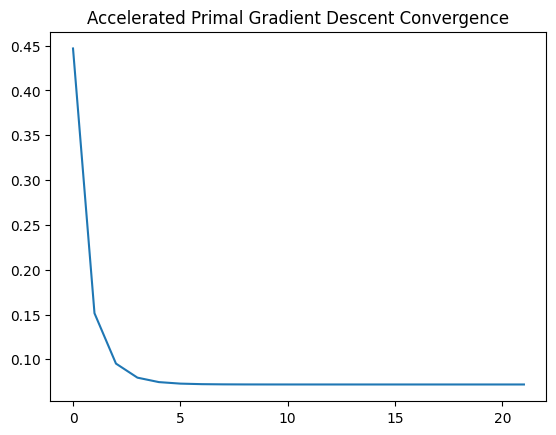

Time taken to run accelerated gradient descent:  0.9006717205047607


In [78]:
start = time.time()
objective_values_primal = accelerated_gradient_descent_primal()
end = time.time()
print("Time taken to run accelerated gradient descent: ", end - start)


0 0.0
1 0.0534281122491206
2 0.053455042931357194
3 0.053487535263541636
4 0.053525385173544146
5 0.05356840367548993
6 0.053616405495450895
7 0.05366920387258331
8 0.05372660811822484
9 0.05378842258100111
10 0.053854446398310676
11 0.053924473717480555
12 0.05399829420992243
13 0.054075693772124775
14 0.05415645534535137
15 0.054240359807680855
16 0.054327186905157705
17 0.05441671619716716
18 0.05450872799672424
19 0.05460300429029542
20 0.054699329624692566
21 0.054797491950863135
22 0.054897283416278225
23 0.0549985010992242
24 0.055100947679719604
25 0.05520443204306019
26 0.05530876981316696
27 0.05541378381399849
28 0.05551930445829477
29 0.05562517006385097
30 0.05573122709837712
31 0.05583733035478229
32 0.05594334305942802
33 0.05604913691652205
34 0.0561545920923715
35 0.05625959714367685
36 0.05636404889443151
37 0.05646785226628907
38 0.05657092006747727
39 0.0566731727454738
40 0.05677453810871895
41 0.05687495102262448
42 0.0569743530850545
43 0.05707269228630644
44 0.0

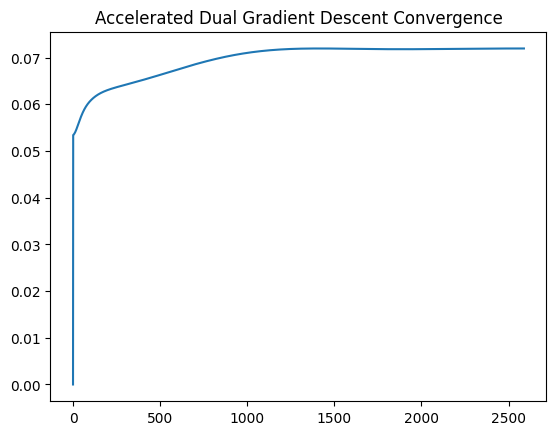

Time taken to run accelerated gradient ascent:  3.7155163288116455


In [79]:
start = time.time()
objective_values_dual = accelerated_gradient_ascent_dual()
end = time.time()
print("Time taken to run accelerated gradient ascent: ", end - start)

In [80]:
# the constant involved in algorithmic complexity

(lambda_max/lambda_min)*(L_rho/mu_rho)

231799.3615703174

0.07195428169162862
0 0.12749660019193568
1 0.12899653704455002
2 0.1276333563624743
3 0.128814856055832
4 0.1277350977031949
5 0.12866506272743022
6 0.12780911608245138
7 0.12854040005076545
8 0.12786119759623335
9 0.1284355528264991
10 0.12789592888222526
11 0.1283463365028694
12 0.1279169428872432
13 0.12826945446066593
14 0.12792711536894621
15 0.12820230821268555
16 0.1279287215863479
17 0.12814284868737302
18 0.1279235609867499
19 0.1280894595094033
20 0.12791305626351832
21 0.12804086527960243
22 0.127898331955876
23 0.12799605942187484
24 0.12788027675133198
25 0.12795424737722771
26 0.12785959283368437
27 0.12791480185107962
28 0.12783683494497097
29 0.127877227538808
30 0.1278124412916828
31 0.12784113330906777
32 0.12778675798891845
33 0.1278062102627295
34 0.1277600583850105
35 0.1277722144201123
36 0.1277325583409612
37 0.127738953059548
38 0.12770442830190598
39 0.12770627393241074
40 0.12767580283934662
41 0.12767405675166174
42 0.12764678818958589
43 0.12764220646990745

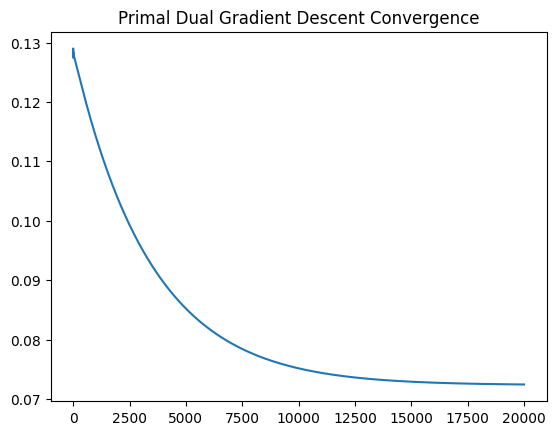

Time taken to run PD gradient descent:  549.5109331607819


In [81]:
start = time.time()
objective_values_pd = primal_dual_gradient_descent(lagrangian, lagrangian_gradient_primal, lagrangian_gradient_dual, 1e-6)
end = time.time()
print("Time taken to run PD gradient descent: ", end - start)

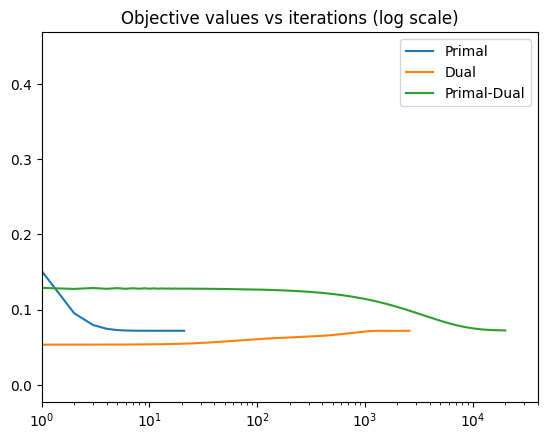

In [84]:
# plot the objective values vs iterations (log scale) for all three methods

plt.plot(objective_values_primal, label="Primal")
plt.plot(objective_values_dual, label="Dual")
plt.plot(objective_values_pd, label="Primal-Dual")
plt.xscale("log")
plt.xlim(1, 2*np.max([len(objective_values_primal), len(objective_values_dual), len(objective_values_pd)]))
plt.legend()
plt.title("Objective values vs iterations (log scale)")
plt.show()

#### d

Now if the regularizer in (7) is $\|\theta\|_1$, derive the saddle-point and dual formulations. Highlight the formula for computing the primal solution using the dual solution

The primal objective with $\ell_1$ regularizer is given by:

$$
\text{MSPBE}(\theta) = \frac{1}{2} \| \hat A \theta - \hat b \|^2_{\hat C^{-1}} + \rho \| \theta \|_1
$$

The saddle-point formulation for the regularizer $\|\theta\|_1$ is given by:

$$
\mathcal{L}(\theta, w) = \frac{\rho}{2} \| \theta \|_1 - w^T \hat A \theta - (\frac{1}{2} w^T \hat C w - w^T \hat b)
$$

The dual objective can be derived by taking the Fenchel dual of the primal objective:

$$
g(w) = \frac{1}{2} w^TCw - w^Tb + I_{A^Tw}(\rho/2)
$$

where $I_{x}(r)$ is the indicator function of the set $\{x: \|x\|_{\infty} \leq r\}$, that is

$$
I_{x}(r) = \begin{cases}
0 & \text{if } \|x\|_{\infty} \leq r\\
\infty & \text{otherwise}
\end{cases}
$$

To compute the primal solution using the dual solution, we can use the following formula:

$$
\theta^* = A^{-1} (b - Cw^*)
$$

where $w^*$ is the optimal dual solution.

In [85]:
# e

def primal_objective_l1(theta):
    return 0.5*((A @ theta - b).T @ np.linalg.pinv(C) @ (A @ theta - b) + (rho/2)*np.linalg.norm(theta, ord=1))

def primal_gradient_l1(theta):
    # return A.T @ np.linalg.pinv(C) @ (A @ theta - b) + (rho/2) * np.sign(theta)
    return A.T @ np.linalg.pinv(C) @ (A @ theta - b)

def dual_objective_l1(w):
    return - 0.5 *  w.T @ C @ w + w.T @ b

def dual_gradient_l1(w):
    return - C @ w + b

def lagrangian_l1(theta, w):
    return (rho/2) * np.linalg.norm(theta, ord=1) - w.T @ A @ theta - 0.5 * w.T @ C @ w + w.T @ b

def lagrangian_gradient_primal_l1(theta, w):
    return (rho/2) * np.sign(theta) - A.T @ w

def lagrangian_gradient_dual_l1(theta, w):
    return b - (A @ theta) - (C @ w)

def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def projection(x, threshold):
    # x[x<0] = np.maximum(x[x<0], -threshold)
    # x[x>0] = np.minimum(x[x>0], threshold)
    # return x
    return np.clip(x, -threshold, threshold)

In [91]:
def proximal_gradient_descent_primal(epsilon):
    x_prev = x = np.zeros(n)
    time_stamps, objective_values = [], []
    i = 0
    l = 1
    l_prev = 0
    z = x.copy()
    Lr = np.linalg.norm(A) ** 2

    start = time.time()
    while True:
        x_prev = x.copy()
        # z = z + A.T.dot(b - A.dot(z))/Lr
        z = z - (1/Lr + 1/(i+1)) * primal_gradient_l1(z)
        x = soft_thresholding(z, rho/(2*Lr))
        l_prev = l
        l = 0.5 * (1 + np.sqrt(1 + 4*l**2))
        z = x + (l_prev - 1)/l * (x - x_prev)
        
        time_stamps.append(time.time() - start)
        objective_values.append(primal_objective_l1(x))

        print(i, primal_objective_l1(x))
        i+=1
        if (i>2 and np.abs(objective_values[-1] - objective_values[-2]) < epsilon )or i>20_000:
            break

    plt.plot(objective_values)
    plt.title('Accelerated Proximal Gradient Descent Convergence on Primal L1')
    plt.show()
    return objective_values, time_stamps

def proximal_gradient_ascent_dual(epsilon):
    w_prev = w = np.zeros(n)
    time_stamps, objective_values = [], []
    i = 0
    l = 1
    l_prev = 0
    z = w.copy()
    Lr = np.linalg.norm(C)

    start = time.time()
    while True:
        w_prev = w.copy()
        z = z + 1/Lr * dual_gradient_l1(z)
        w = projection(z, rho/2)
        l_prev = l
        l = 0.5 * (1 + np.sqrt(1 + 4*l**2))
        z = w + (l_prev - 1)/l * (w - w_prev)

        time_stamps.append(time.time() - start) 
        objective_values.append(dual_objective_l1(w))
        
        print(i, dual_objective_l1(w))
        i+=1
        if (i>2 and np.abs(objective_values[-1] - objective_values[-2]) < epsilon )or i>20_000:
            break

    plt.plot(objective_values)
    plt.title('Accelerated Proximal Gradient Descent Convergence on Dual L1')
    plt.show()
    return objective_values, time_stamps

0 0.15151462867627033
1 0.1545813048344435
2 0.15303601416417048
3 0.1478987503258366
4 0.14115303215663003
5 0.13494381412765064
6 0.13122875036352288
7 0.12968632975793032
8 0.12929930934335732
9 0.12921445399933348
10 0.12921445831684242


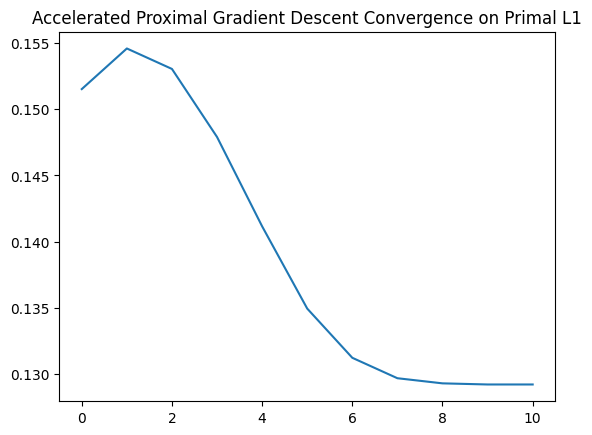

Time taken to run proximal gradient descent:  0.5410053730010986


In [92]:
start = time.time()
objective_values_primal_l1, time_stamps_primal_l1 = proximal_gradient_descent_primal(1e-6)
end = time.time()
print("Time taken to run proximal gradient descent: ", end - start)

0 0.1263711240489076
1 0.12638004154415933
2 0.1263913906291817
3 0.12640508855486837
4 0.12642105176172175
5 0.12643920313429013
6 0.12645946710917894
7 0.12648176737906408
8 0.12650602575539466
9 0.12653216162235964
10 0.12656009172312094
11 0.12658973014688119
12 0.12662098844428663
13 0.12665377582828583
14 0.12668799943347464
15 0.12672356461598833
16 0.1267603752813744
17 0.12679833423120795
18 0.12683734352135667
19 0.1268773048262422
20 0.12691811980444034
21 0.12695969046168987
22 0.1270019195079286
23 0.1270447107054065
24 0.12708796920528892
25 0.12713160187046746
26 0.12717551758257564
27 0.1272196275314555
28 0.12726384548556152
29 0.1273080880420127
30 0.12735227485522044
31 0.12739632884323132
32 0.12744017637112834
33 0.12748374741102975
34 0.12752697567841914
35 0.127569798744724
36 0.12761215812623738
37 0.12765399934964794
38 0.12769527199460243
39 0.12773592971387823
40 0.12777593023188194
41 0.1278152353223222
42 0.12785381076602045
43 0.1278916262899334
44 0.12792

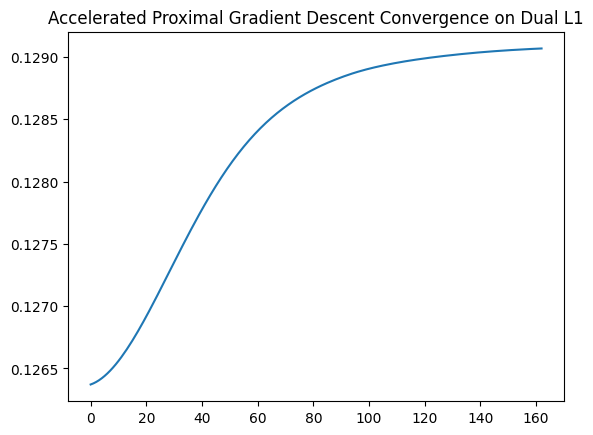

Time taken to run proximal gradient descent:  0.25614476203918457


In [93]:
start = time.time()
objective_values_dual_l1, time_stamps_dual_l1 = proximal_gradient_ascent_dual(1e-6)
end = time.time()
print("Time taken to run proximal gradient descent: ", end - start)

In [94]:
def coordinate_prox_gradient_descent_primal(epsilon):
    x = np.ones(n)
    time_stamps, objective_values = [], []
    i = 0
    start = time.time()
    while True:
        for j in range(n):
            # x[j] = soft_thresholding(x[j] + A[j].dot(b - A.dot(x))/L, rho/L)
            x[j] = soft_thresholding(x[j] - 2/L * primal_gradient_l1(x)[j], rho/(2*L))
        time_stamps.append(time.time() - start)
        objective_values.append(primal_objective_l1(x))
        print(i, primal_objective_l1(x))
        i+=1
        if (i>2 and np.abs(objective_values[-1] - objective_values[-2]) < epsilon )or i>20_000:
            break

    plt.plot(objective_values)
    plt.title('Coordinate Proximal Gradient Descent Convergence on Primal L1')
    plt.show()
    return objective_values, time_stamps

0 1.413619425419065
1 0.4018670747029559
2 0.1600951637314985
3 0.13023932057006088
4 0.12965448506683505
5 0.1296420889969918
6 0.129630042124889
7 0.12961833461379285
8 0.12960695690375798
9 0.12959589970441412
10 0.12958515398681733
11 0.12957471097665685
12 0.12956456214626605
13 0.12955469920912213
14 0.1295451141112959
15 0.1295357990261116
16 0.12952674634724132
17 0.12951794868272548
18 0.12950939884892265
19 0.1295010898642383
20 0.1294930149439772
21 0.12948516749467115
22 0.1294775411083128
23 0.12947012955765277
24 0.12946292679057197
25 0.12945592692578897
26 0.12944912424773988
27 0.1294425132010977
28 0.12943608838808857
29 0.1294298445623291
30 0.12942377662548618
31 0.1294178796225284
32 0.12941214873852666
33 0.12940657929375715
34 0.1294011667405095
35 0.12939590665903158
36 0.12939079475454404
37 0.12938582685235717
38 0.12938099889630705
39 0.12937630694391114
40 0.12937174716413777
41 0.12936731583339653
42 0.12936300933365763
43 0.12935882414802766
44 0.129354756

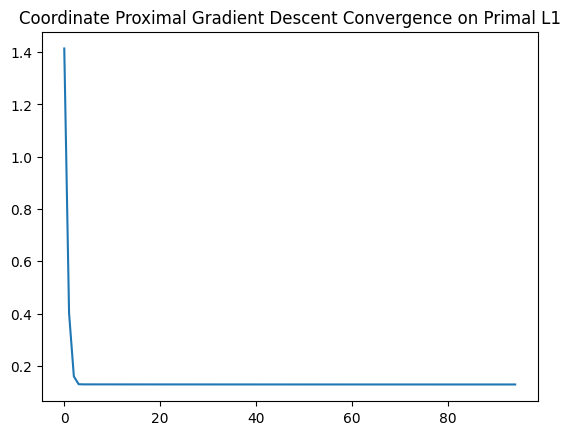

Time taken to run coordinate proximal gradient descent:  167.62688779830933


In [95]:
start = time.time()
objective_values_coord_l1, time_stamps_coord_l1 = coordinate_prox_gradient_descent_primal(1e-6)
end = time.time()
print("Time taken to run coordinate proximal gradient descent: ", end - start)

In [96]:
def coordinate_prox_gradient_descent_primal_dual(epsilon):
    x = np.zeros(n)
    w = np.zeros(n)
    xold = x
    wold = w
    time_stamps, objective_values = [], []
    i = 0
    Lr = np.linalg.norm(A) ** 2
    start = time.time()
    while True:
        for j in range(n):
            x[j] = soft_thresholding(x[j] - (1/Lr + 1/(i+1)) * (rho/2) * (np.sign(x) - A.T @ wold)[j], rho/(20*Lr))
        for j in range(n):
            w[j] = w[j] + (1/Lr + 1/(i+1)) * (b - (A @ xold) - (C @ w))[j]

        time_stamps.append(time.time() - start)
        objective_values.append(primal_objective_l1(x))
        print(i, primal_objective_l1(x))
        i+=1
        if (i>2 and np.abs(objective_values[-1] - objective_values[-2]) < epsilon )or i>20_000:
            break

    plt.plot(objective_values)
    plt.title('Coordinate Proximal Primal-Dual GD on L1')
    plt.show()
    return objective_values, time_stamps

0 0.12921870465349578
1 0.12923243817476773
2 0.13612790196354532
3 0.12984782627557126
4 0.1302947968054128
5 0.12922973285159395
6 0.12996138447851213
7 0.12922155238353347


8 0.13043975809499977
9 0.12921965699352414
10 0.12958868218885444
11 0.12922145611942282
12 0.12955340797134227
13 0.12922381828738636
14 0.12952322331359944
15 0.1292264918061629
16 0.1294965724640761
17 0.12922934283805487
18 0.1294725042678699
19 0.12923229535519393
20 0.12945040035900507
21 0.12923530401209635
22 0.12942983881926978
23 0.12923834076699525
24 0.1294105203043438
25 0.12924138781602554
26 0.12939222547752074
27 0.12924443365245836
28 0.129374789215524
29 0.129247470764259
30 0.12935808430861553
31 0.12925049424100132
32 0.1293420107849088
33 0.12925350090110305
34 0.12932648870601698
35 0.12925648873159382
36 0.1293114531706788
37 0.12925945652023466
38 0.12929685076900585
39 0.12926240360809063
40 0.12928263701626666
41 0.12926532972116753
42 0.129268774458793
43 0.12926823485402444


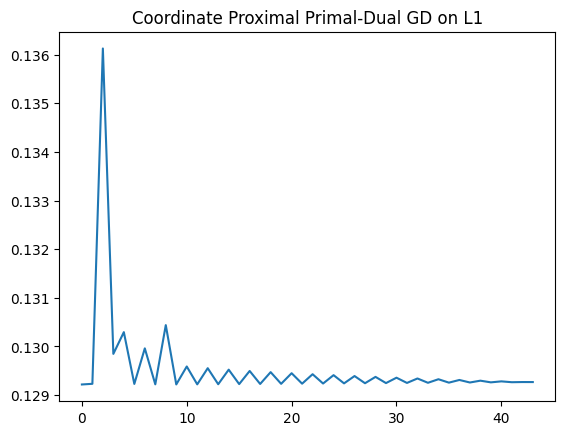

Time taken to run coordinate proximal gradient descent:  1.4241819381713867


In [97]:
start = time.time()
objective_values_pd_l1, time_stamps_pd_l1 = coordinate_prox_gradient_descent_primal_dual(1e-6)
end = time.time()
print("Time taken to run coordinate proximal gradient descent: ", end - start)

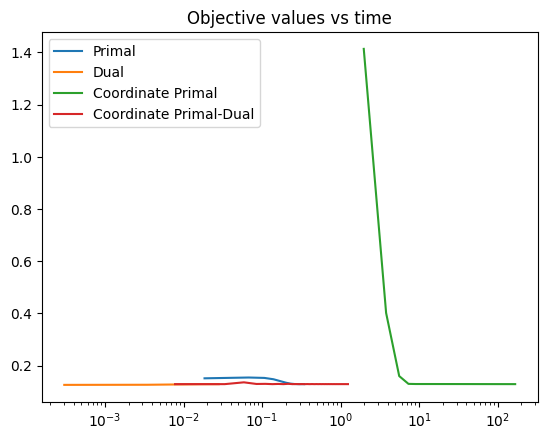

In [99]:
# plot the objective values vs time for all three methods

plt.plot(time_stamps_primal_l1, objective_values_primal_l1, label="Primal")
plt.plot(time_stamps_dual_l1, objective_values_dual_l1, label="Dual")
plt.plot(time_stamps_coord_l1, objective_values_coord_l1, label="Coordinate Primal")
plt.plot(time_stamps_pd_l1, objective_values_pd_l1, label="Coordinate Primal-Dual")
plt.legend()
plt.xscale("log")
plt.title("Objective values vs time")
plt.show()
